In [1]:
import sys
import os

func_folder_path = os.path.abspath('../functions')
sys.path.append(func_folder_path)

In [2]:
from opt_utils import *

# Parameters

In [3]:
prediction_range = 7*24

history_range = 12*24

smoothing_window = 12

d_average = 3
market_demands = [d_average]*(prediction_range//24)

# Data

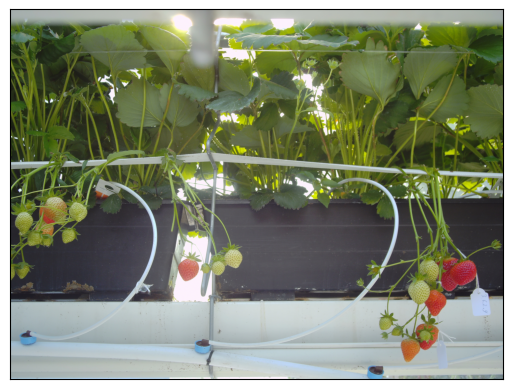

In [4]:
cam = 'RGBCAM3'
cr_gt_gsd = np.load(os.path.join(basePath, 'example_data', f'2021_RGBCAM{cam[-1]}_20241205-GW_final.npy'))

check_frame = 1000

frame_info_ = pd.read_csv(os.path.join(basePath, 'example_data', 'img_dict_cam3.csv'), index_col=0)

# img_name = frame_info_[frame_info_['frame_n']==check_frame]['file_name'].values[0]
# img_file = os.path.join(img_folder,img_name)
img_file = os.path.join(basePath,'example_data','2021_0604_094547_092.JPG')
im = cv2.imread(img_file)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.xticks([]);
plt.yticks([]);

In [5]:
import pickle

with open('../example_data/history_states.pkl', 'rb') as f:
    history_states = pickle.load(f)

predicted_states = np.load('../example_data/lbk-12_prediction_1209.npy')
check_tracks_sorted = np.load('../example_data/check_tracks_sorted_1209.npy')

rainbow_cycle = plt.cm.hsv(np.linspace(0, 1, len(history_states))) * 0.8


# Scoring functions

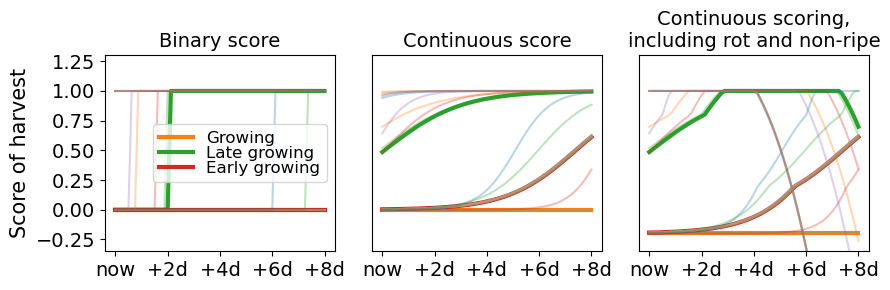

In [6]:
discretized = 3

titles = ['Growing','Late growing','Early growing']
plt.subplots(1,3,figsize=(9,3))

plt.subplot(1,3,1)
for ii,idx in enumerate([24,3,16]):
    states = predicted_states[idx]
    # if ii!=1:
    #     states = predicted_states[idx]
    # else:
    #     states = virtual_states
    plt.plot(binary_score(states)[::discretized], label=titles[ii], color=color_cycle[ii+1], linewidth=3)
for ii,idx in enumerate([i for i in range(len(predicted_states)) if i not in [24,3,16]]):
    plt.plot(binary_score(predicted_states[idx])[::discretized],color=color_cycle[ii%12], alpha=0.3)
                        

plt.xticks(np.arange(0,200,48)//discretized,['now'] + [f'+{d//24}d' for d in range(48,prediction_range+25,48)], fontsize=14)
plt.ylim(-0.35,1.3)
plt.title('Binary score', fontsize=14)
plt.ylabel('Score of harvest', fontsize=15)
plt.legend(fontsize=12, labelspacing=0)
plt.yticks(fontsize=14)


plt.subplot(1,3,2)
for ii,idx in enumerate([24,3,16]):
    states = predicted_states[idx]
    plt.plot(continue_score(states)[::discretized], label=titles[ii], color=color_cycle[ii+1], linewidth=3)
for ii,idx in enumerate([i for i in range(len(predicted_states)) if i not in [24,3,16]]):
    plt.plot(continue_score(predicted_states[idx])[::discretized],color=color_cycle[ii%12], alpha=0.3)

plt.xticks(np.arange(0,200,48)//discretized,['now'] + [f'+{d//24}d' for d in range(48,prediction_range+25,48)], fontsize=14)
plt.ylim(-0.35,1.3)
plt.title('Continuous score', fontsize=14)
plt.yticks([])


plt.subplot(1,3,3)
for ii,idx in enumerate([24,3,16]):
    states = predicted_states[idx]
    plt.plot(rot_score_cubic_neg(states)[::discretized], label=titles[ii], color=color_cycle[ii+1], linewidth=3)
for ii,idx in enumerate([i for i in range(len(predicted_states)) if i not in [24,3,16]]):
    plt.plot(rot_score_cubic_neg(predicted_states[idx])[::discretized],color=color_cycle[ii%12], alpha=0.3)

plt.xticks(np.arange(0,200,48)//discretized,['now'] + [f'+{d//24}d' for d in range(48,prediction_range+25,48)], fontsize=14)
plt.ylim(-0.35,1.3)
plt.title('Continuous scoring,\nincluding rot and non-ripe', fontsize=14)
plt.yticks([])

plt.tight_layout()


# Harvest Optimization

In [7]:
harvest_score_bi = binary_score_matrix(predicted_states)
harvest_score_cont = continue_score_matrix(predicted_states)
harvest_score_rot = combined_score_matrix(predicted_states)

In [8]:
market_demands = [d_average]*(prediction_range//24)# + [len(check_tracks)]
cost_matrix, trade_dates = harvest_cost(harvest_score_rot, market_demands, over_supply=0.5, dummy_demands=True)
harvest_time = harvest_optimize(cost_matrix, trade_dates)

element_counts = Counter(harvest_time)
harvest_count = np.zeros(prediction_range//24+1)
for i,ht in enumerate(np.arange(1,8,1)):
    if ht in element_counts.keys():
        harvest_count[i] = element_counts[ht]
harvest_count = np.vstack((np.arange(24,prediction_range+36,24),harvest_count.reshape(1,-1)))        

## Plan visualization

In [9]:
check_tracks = np.unique(cr_gt_gsd[cr_gt_gsd[:,0]==check_frame][:,1])
check_tracks = check_tracks[check_tracks!=153]

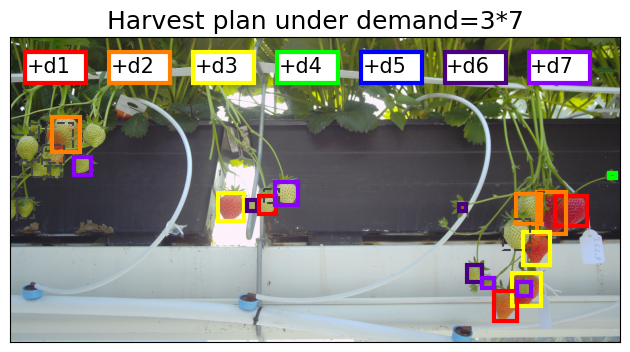

In [11]:
im = cv2.imread(img_file)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.xticks([]);
plt.yticks([]);

for i,tr in enumerate(check_tracks_sorted):
    bbox = cr_gt_gsd[(cr_gt_gsd[:,0]==check_frame)&(cr_gt_gsd[:,1]==tr)][0,2:6]
    x,y,w,h = bbox
    tt = int(harvest_time[i])-1
    if tt<7:
        rect = Rectangle((x, y), w, h, linewidth=3, edgecolor=rainbow_colors[tt], facecolor='none')
    else:
        rect = Rectangle((x, y), w, h, linewidth=1.5, edgecolor=rainbow_colors[tt], linestyle='--', facecolor='none')
    plt.gca().add_patch(rect)

x0,y0,w0,h0 = 100,1100,400,200

for i in range(7):
    rect = Rectangle((x0+550*i, y0), w0, h0, linewidth=3, edgecolor=rainbow_colors[i], facecolor='white')
    plt.gca().add_patch(rect)
    text_x = x0+550*i + 10  # Position the text to the right of the rectangle
    text_y = y0 + 30  # Position the text vertically centered with the rectangle
    plt.text(text_x, text_y, f'+d{i+1}', color='black', fontsize=15, va='top')

plt.ylim(3000,1000)

plt.title('Harvest plan under demand=3*7', fontsize=18)
plt.tight_layout()
# plt.savefi('plan_visualization.pdf')

## Plan evaluation

In [12]:
cost_matrix, trade_dates = harvest_cost(harvest_score_rot, market_demands, over_supply=0.5, dummy_demands=True)
harvest_time = harvest_optimize(cost_matrix, trade_dates)

In [18]:
for d in [3,4,5]:
    print(plan_evaluation(predicted_states, daily_demand=d))

(13.412335648205094, 76.19047619047619)
(14.516747501021381, 64.28571428571429)
(15.199113805196621, 57.14285714285714)
